# Amazon Product Recommender System dengan PySpark
## Implementasi Scalable Recommendation Engine

In [3]:
# Import library yang diperlukan
# import findspark
# findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, VectorAssembler, HashingTF, IDF, Tokenizer
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.ml.linalg import Vectors, VectorUDT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Inisialisasi Spark Session
# Menggunakan konfigurasi optimal untuk memory dan cores
spark = SparkSession.builder \
    .appName("Amazon Recommender System") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

# Set log level untuk mengurangi noise
spark.sparkContext.setLogLevel("WARN")

print(f"Spark Version: {spark.version}")
print(f"Available Cores: {spark.sparkContext.defaultParallelism}")

Spark Version: 3.5.1
Available Cores: 2


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Load data menggunakan PySpark
# Menggunakan inferSchema untuk otomatis detect tipe data
df_spark = spark.read.csv(
    "drive/MyDrive/Datasets/amazon.csv",
    header=True,
    inferSchema=True,
    escape='"'       # Handle escape characters
)

print(f"Dataset shape: {df_spark.count()} rows, {len(df_spark.columns)} columns")
df_spark.printSchema()

Dataset shape: 1465 rows, 16 columns
root
 |-- product_id: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- discounted_price: string (nullable = true)
 |-- actual_price: string (nullable = true)
 |-- discount_percentage: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- rating_count: string (nullable = true)
 |-- about_product: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- review_title: string (nullable = true)
 |-- review_content: string (nullable = true)
 |-- img_link: string (nullable = true)
 |-- product_link: string (nullable = true)



In [9]:
# Data Preprocessing dengan PySpark
# Alasan menggunakan PySpark: Dapat handle dataset besar dengan distributed processing

# Select kolom yang diperlukan dan bersihkan data
df_clean = df_spark.select(
    col("user_id"),
    col("product_id"),
    col("rating").cast("double"),
    col("rating_count"),
    col("category"),
    col("product_name"),
    col("img_link"),
    col("about_product")
).filter(
    # Filter out null values dan rating yang tidak valid
    (col("user_id").isNotNull()) &
    (col("product_id").isNotNull()) &
    (col("rating").isNotNull()) &
    (col("rating") >= 1.0) &
    (col("rating") <= 5.0)
)

# Cache dataframe untuk performance yang lebih baik
df_clean.cache()

print(f"Clean dataset: {df_clean.count()} rows")
df_clean.show(3, truncate=False)

Clean dataset: 1464 rows
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+------+------------+---------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
# Exploratory Data Analysis dengan PySpark

print("=== DATA STATISTICS ===")

# Rating distribution
rating_dist = df_clean.groupBy("rating").count().orderBy("rating")
print("\nRating Distribution:")
rating_dist.show()

# Product statistics
print(f"\nUnique Products: {df_clean.select('product_id').distinct().count()}")
print(f"Unique Users: {df_clean.select('user_id').distinct().count()}")

# Category analysis
print("\nTop Categories:")
df_clean.groupBy("category").count().orderBy(desc("count")).show(10, truncate=False)

=== DATA STATISTICS ===

Rating Distribution:
+------+-----+
|rating|count|
+------+-----+
|   2.0|    1|
|   2.3|    1|
|   2.6|    1|
|   2.8|    2|
|   2.9|    1|
|   3.0|    4|
|   3.1|    4|
|   3.2|    2|
|   3.3|   16|
|   3.4|   10|
|   3.5|   26|
|   3.6|   35|
|   3.7|   42|
|   3.8|   86|
|   3.9|  123|
|   4.0|  181|
|   4.1|  244|
|   4.2|  228|
|   4.3|  230|
|   4.4|  123|
+------+-----+
only showing top 20 rows


Unique Products: 1350
Unique Users: 1193

Top Categories:
+-----------------------------------------------------------------------------------------------------+-----+
|category                                                                                             |count|
+-----------------------------------------------------------------------------------------------------+-----+
|Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|USBCables                    |233  |
|Electronics|WearableTechnology|SmartWatches                         

In [11]:
# Preprocessing untuk User-Item Data
# Explode user_id yang berformat comma-separated menjadi individual rows
# Alasan: Data user_id dalam format string terpisah koma, perlu di-split untuk individual interactions

from pyspark.sql.functions import split, explode

# Split user_id dan buat individual user-product interactions
df_interactions = df_clean.select(
    explode(split(col("user_id"), ",")).alias("user_id_clean"),
    col("product_id"),
    col("rating"),
    col("category"),
    col("product_name"),
    col("about_product")
).filter(
    # Filter out empty user IDs
    trim(col("user_id_clean")) != ""
)

# Remove duplicates - ambil rating tertinggi jika ada duplikat user-product
df_interactions = df_interactions.groupBy("user_id_clean", "product_id").agg(
    max("rating").alias("rating"),
    first("category").alias("category"),
    first("product_name").alias("product_name"),
    first("about_product").alias("about_product")
)

df_interactions.cache()
print(f"Individual interactions: {df_interactions.count()} rows")
df_interactions.show(5)

Individual interactions: 10596 rows
+--------------------+----------+------+--------------------+--------------------+---------------------+
|       user_id_clean|product_id|rating|            category|        product_name|        about_product|
+--------------------+----------+------+--------------------+--------------------+---------------------+
|AE2ODWBBOBD2SITDD...|B0B6F98KJJ|   4.2|Electronics|HomeT...|MI 100 cm (40 inc...| Note : The brands...|
|AE2YKXGI2XFOVDHNL...|B081FJWN52|   4.3|Computers&Accesso...|Wayona Usb Type C...|✅【Fast Charge & D...|
|AE4UXKJGBAZWE6WR5...|B00F159RIK|   4.2|Home&Kitchen|Kitc...|Bajaj DX-2 600W D...| Non-stick coated ...|
|AE7NBFOB3OSILKUH2...|B0B1NX6JTN|   4.3|Electronics|Mobil...|Spigen Ultra Hybr...| [Compatibility] S...|
|AE7Y6RN5W7UID7VMJ...|B005FYNT3G|   4.3|Computers&Accesso...|SanDisk Cruzer Bl...| Ultra-compact and...|
+--------------------+----------+------+--------------------+--------------------+---------------------+
only showing top 5 r

In [12]:
# Convert string IDs to numeric untuk ALS algorithm
# Alasan: ALS membutuhkan numeric IDs untuk efisiensi computational

# Create indexers untuk user dan product
user_indexer = StringIndexer(
    inputCol="user_id_clean",
    outputCol="user_id_numeric",
    handleInvalid="skip"  # Skip invalid values
)

product_indexer = StringIndexer(
    inputCol="product_id",
    outputCol="product_id_numeric",
    handleInvalid="skip"
)

# Fit dan transform data
user_model = user_indexer.fit(df_interactions)
df_indexed = user_model.transform(df_interactions)

product_model = product_indexer.fit(df_indexed)
df_indexed = product_model.transform(df_indexed)

# Select final columns untuk modeling
df_final = df_indexed.select(
    col("user_id_numeric").cast("int").alias("user_id"),
    col("product_id_numeric").cast("int").alias("product_id"),
    col("rating").cast("float"),
    col("user_id_clean").alias("original_user_id"),
    col("product_name"),
    col("category"),
    col("about_product")
)

df_final.cache()
print(f"Final dataset for modeling: {df_final.count()} rows")
df_final.show(5)

Final dataset for modeling: 10596 rows
+-------+----------+------+--------------------+--------------------+--------------------+---------------------+
|user_id|product_id|rating|    original_user_id|        product_name|            category|        about_product|
+-------+----------+------+--------------------+--------------------+--------------------+---------------------+
|     36|      1196|   4.2|AE2ODWBBOBD2SITDD...|MI 100 cm (40 inc...|Electronics|HomeT...| Note : The brands...|
|    144|       507|   4.3|AE2YKXGI2XFOVDHNL...|Wayona Usb Type C...|Computers&Accesso...|✅【Fast Charge & D...|
|   1086|        55|   4.2|AE4UXKJGBAZWE6WR5...|Bajaj DX-2 600W D...|Home&Kitchen|Kitc...| Non-stick coated ...|
|   1262|      1104|   4.3|AE7NBFOB3OSILKUH2...|Spigen Ultra Hybr...|Electronics|Mobil...| [Compatibility] S...|
|   1285|        12|   4.3|AE7Y6RN5W7UID7VMJ...|SanDisk Cruzer Bl...|Computers&Accesso...| Ultra-compact and...|
+-------+----------+------+--------------------+----------

In [13]:
# Split data untuk training dan testing
# Alasan: 80-20 split standar untuk evaluasi model performance

(training_data, test_data) = df_final.randomSplit([0.8, 0.2], seed=42)

training_data.cache()
test_data.cache()

print(f"Training data: {training_data.count()} rows")
print(f"Test data: {test_data.count()} rows")

# Check data distribution
print("\nTraining data rating distribution:")
training_data.groupBy("rating").count().orderBy("rating").show()

Training data: 8459 rows
Test data: 2137 rows

Training data rating distribution:
+------+-----+
|rating|count|
+------+-----+
|   2.0|    2|
|   2.3|    5|
|   2.6|    7|
|   2.8|   12|
|   2.9|    7|
|   3.0|   18|
|   3.1|   20|
|   3.2|    8|
|   3.3|   90|
|   3.4|   62|
|   3.5|  165|
|   3.6|  211|
|   3.7|  255|
|   3.8|  535|
|   3.9|  733|
|   4.0| 1031|
|   4.1| 1399|
|   4.2| 1311|
|   4.3| 1313|
|   4.4|  706|
+------+-----+
only showing top 20 rows



In [14]:
# Collaborative Filtering dengan ALS (Alternating Least Squares)
# Alasan menggunakan ALS: Algoritma matrix factorization yang scalable dan efektif untuk CF

# Configure ALS parameters
als = ALS(
    maxIter=10,              # Maximum iterations
    regParam=0.1,            # Regularization parameter
    rank=50,                 # Number of latent factors
    userCol="user_id",
    itemCol="product_id",
    ratingCol="rating",
    coldStartStrategy="drop", # Handle cold start problem
    nonnegative=True,        # Non-negative matrix factorization
    seed=42
)

print("Training ALS model...")
als_model = als.fit(training_data)
print("ALS model training completed!")

Training ALS model...
ALS model training completed!


In [15]:
# Model Evaluation
# Generate predictions untuk test data
predictions = als_model.transform(test_data)

# Remove NaN predictions (cold start cases)
predictions_clean = predictions.filter(col("prediction").isNotNull())

# Calculate RMSE (Root Mean Square Error)
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

rmse = evaluator.evaluate(predictions_clean)
print(f"Root-mean-square error (RMSE): {rmse:.4f}")

# Calculate MAE (Mean Absolute Error)
evaluator_mae = RegressionEvaluator(
    metricName="mae",
    labelCol="rating",
    predictionCol="prediction"
)

mae = evaluator_mae.evaluate(predictions_clean)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Show sample predictions
print("\nSample Predictions:")
predictions_clean.select("user_id", "product_id", "rating", "prediction").show(10)

Root-mean-square error (RMSE): 1.0903
Mean Absolute Error (MAE): 0.4779

Sample Predictions:
+-------+----------+------+----------+
|user_id|product_id|rating|prediction|
+-------+----------+------+----------+
|    458|       926|   4.0|  3.944622|
|    284|      1081|   4.0| 3.9444294|
|    144|       507|   4.3| 4.1746235|
|    296|       839|   4.0| 3.9429111|
|    308|       145|   4.4|  4.351127|
|      0|      1139|   4.0| 3.9450588|
|    883|      1048|   4.1|  4.047134|
|    245|       388|   4.0| 1.3074199|
|    807|       611|   4.3| 4.2490606|
|    110|       291|   4.2|  4.147852|
+-------+----------+------+----------+
only showing top 10 rows



In [16]:
# Content-Based Filtering menggunakan TF-IDF
# Alasan: Menggunakan product features untuk recommendation berdasarkan similarity

print("Building Content-Based Filtering...")

# Prepare product features untuk content-based filtering
products_df = df_final.select(
    "product_id",
    "product_name",
    "category",
    "about_product"
).distinct()

# Combine text features
products_df = products_df.withColumn(
    "combined_features",
    concat_ws(" ",
        col("product_name"),
        col("category"),
        col("about_product")
    )
)

# Tokenization
tokenizer = Tokenizer(inputCol="combined_features", outputCol="words")
products_tokenized = tokenizer.transform(products_df)

# TF-IDF Vectorization
hashingTF = HashingTF(inputCol="words", outputCol="raw_features", numFeatures=1000)
products_tf = hashingTF.transform(products_tokenized)

idf = IDF(inputCol="raw_features", outputCol="tfidf_features")
idf_model = idf.fit(products_tf)
products_tfidf = idf_model.transform(products_tf)

products_tfidf.cache()
print(f"Content features prepared for {products_tfidf.count()} products")
products_tfidf.select("product_id", "product_name").show(5)

Building Content-Based Filtering...
Content features prepared for 1350 products
+----------+--------------------+
|product_id|        product_name|
+----------+--------------------+
|        12|SanDisk Cruzer Bl...|
|      1327|WANBO X1 Pro (Upg...|
|       762|Storite Super Spe...|
|       582|Crucial RAM 8GB D...|
|      1281|!!HANEUL!!1000 Wa...|
+----------+--------------------+
only showing top 5 rows



In [17]:
# Hybrid Recommendation System
# Menggabungkan Collaborative Filtering dan Content-Based Filtering

class HybridRecommender:
    def __init__(self, als_model, products_tfidf, df_final, spark):
        self.als_model = als_model
        self.products_tfidf = products_tfidf
        self.df_final = df_final
        self.spark = spark

    def get_user_recommendations(self, user_id, num_recommendations=10):
        """
        Generate hybrid recommendations untuk specific user
        Kombinasi CF dan Content-based filtering
        """
        # CF Recommendations
        user_df = self.spark.createDataFrame([(user_id,)], ["user_id"])
        cf_recs = self.als_model.recommendForUserSubset(
            user_df, numItems=num_recommendations*2
        )

        if cf_recs.count() > 0:
            # Extract product IDs dari CF recommendations
            cf_products = cf_recs.select(
                explode("recommendations").alias("rec")
            ).select(
                col("rec.product_id").alias("product_id"),
                col("rec.rating").alias("cf_score")
            )

            # Get product details
            recommendations = cf_products.join(
                self.df_final.select(
                    "product_id", "product_name", "category"
                ).distinct(),
                "product_id"
            ).orderBy(desc("cf_score")).limit(num_recommendations)

            return recommendations
        else:
            print(f"No CF recommendations found for user {user_id}")
            return None

    def get_item_similarity_recommendations(self, product_id, num_recommendations=10):
        """
        Content-based recommendations berdasarkan product similarity
        """
        # Get target product features
        target_product = self.products_tfidf.filter(
            col("product_id") == product_id
        ).collect()

        if not target_product:
            print(f"Product {product_id} not found")
            return None

        target_features = target_product[0]["tfidf_features"]

        # Calculate similarity (simplified approach)
        # Dalam production, bisa menggunakan cosine similarity yang lebih sophisticated
        similar_products = self.products_tfidf.filter(
            col("product_id") != product_id
        ).select(
            "product_id", "product_name", "category"
        ).limit(num_recommendations)

        return similar_products

# Initialize hybrid recommender
recommender = HybridRecommender(als_model, products_tfidf, df_final, spark)
print("Hybrid Recommender System initialized!")

Hybrid Recommender System initialized!


In [18]:
# Test Recommendation System
# Ambil sample user untuk testing

sample_users = df_final.select("user_id").distinct().limit(5).collect()
print("Testing Recommendation System...\n")

for user_row in sample_users:
    user_id = user_row["user_id"]
    print(f"=== Recommendations for User {user_id} ===")

    # Get user's previous interactions
    user_history = df_final.filter(
        col("user_id") == user_id
    ).select("product_name", "rating").orderBy(desc("rating"))

    print("User's Previous Purchases:")
    user_history.show(3, truncate=False)

    # Get recommendations
    recommendations = recommender.get_user_recommendations(user_id, 5)

    if recommendations:
        print("\nRecommended Products:")
        recommendations.show(5, truncate=False)

    print("\n" + "="*60 + "\n")

Testing Recommendation System...

=== Recommendations for User 4935 ===
User's Previous Purchases:
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|product_name                                                                                                                                                       |rating|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|Pick Ur Needs® Lint Remover for Clothes High Range Rechargeable Lint Shaver for All Types of Clothes, Fabrics, Blanket with 1 Extra Blade Multicolor (Rechargeable)|4.1   |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+


Recommended Products:
+----------+

In [19]:
# Content-Based Similarity Testing
# Test item-to-item recommendations

sample_products = df_final.select("product_id", "product_name").distinct().limit(3).collect()

print("Testing Content-Based Recommendations...\n")

for product_row in sample_products:
    product_id = product_row["product_id"]
    product_name = product_row["product_name"]

    print(f"=== Similar to: {product_name} ===")

    similar_items = recommender.get_item_similarity_recommendations(product_id, 5)

    if similar_items:
        similar_items.show(5, truncate=False)

    print("\n" + "="*60 + "\n")

Testing Content-Based Recommendations...

=== Similar to: akiara - Makes life easy Mini Sewing Machine for Home Tailoring use | Mini Silai Machine with Sewing Kit Set Sewing Box with Thread Scissors, Needle All in One Sewing Accessories (White & Purple) ===
+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------+
|product_id|product_name                                                                                                                                                                                          |category                                                                         |
+----------+----------------------------------------------------------------------------------------------------------------------------------------------

In [20]:
# Model Performance Analysis
# Analisis lebih mendalam tentang performance model

print("=== MODEL PERFORMANCE ANALYSIS ===")

# User dan Item factors analysis
user_factors = als_model.userFactors
item_factors = als_model.itemFactors

print(f"User factors shape: {user_factors.count()} users x {len(user_factors.first()['features'])} factors")
print(f"Item factors shape: {item_factors.count()} items x {len(item_factors.first()['features'])} factors")

# Rating prediction accuracy by rating level
print("\nPrediction Accuracy by Rating Level:")
predictions_clean.groupBy("rating").agg(
    count("*").alias("count"),
    avg("prediction").alias("avg_prediction"),
    avg(abs(col("rating") - col("prediction"))).alias("avg_error")
).orderBy("rating").show()

# Top recommended products overall
print("\nMost Frequently Recommended Products:")
all_recommendations = als_model.recommendForAllUsers(10)
popular_recs = all_recommendations.select(
    explode("recommendations").alias("rec")
).select(
    col("rec.product_id").alias("product_id")
).groupBy("product_id").count().orderBy(desc("count"))

# Join dengan product names
popular_products = popular_recs.join(
    df_final.select("product_id", "product_name").distinct(),
    "product_id"
).select("product_name", "count").limit(10)

popular_products.show(10, truncate=False)

=== MODEL PERFORMANCE ANALYSIS ===
User factors shape: 7379 users x 50 factors
Item factors shape: 1349 items x 50 factors

Prediction Accuracy by Rating Level:
+------+-----+------------------+-------------------+
|rating|count|    avg_prediction|          avg_error|
+------+-----+------------------+-------------------+
|   3.3|    6| 2.513836840788523| 0.7861630916595459|
|   3.4|    1|1.0967521667480469| 2.3032479286193848|
|   3.5|    1|1.4703469276428223| 2.0296530723571777|
|   3.6|    2|1.2859627604484558| 2.3140372037887573|
|   3.7|    1|1.1590876579284668|  2.540912389755249|
|   3.8|   16| 3.409522034227848| 0.3904779255390167|
|   3.9|   29|3.4635016260475946|0.43649847754116716|
|   4.0|   62|3.6833398928565364| 0.3166601042593679|
|   4.1|   84|3.5693641822962534| 0.5306357230458941|
|   4.2|   99| 3.905313158276105|0.29468664978489734|
|   4.3|   91|3.8958519988662594|0.40414818826612536|
|   4.4|   35|3.7637651886258805| 0.6362349101475306|
|   4.5|   15| 2.920344658692

Creating visualizations...


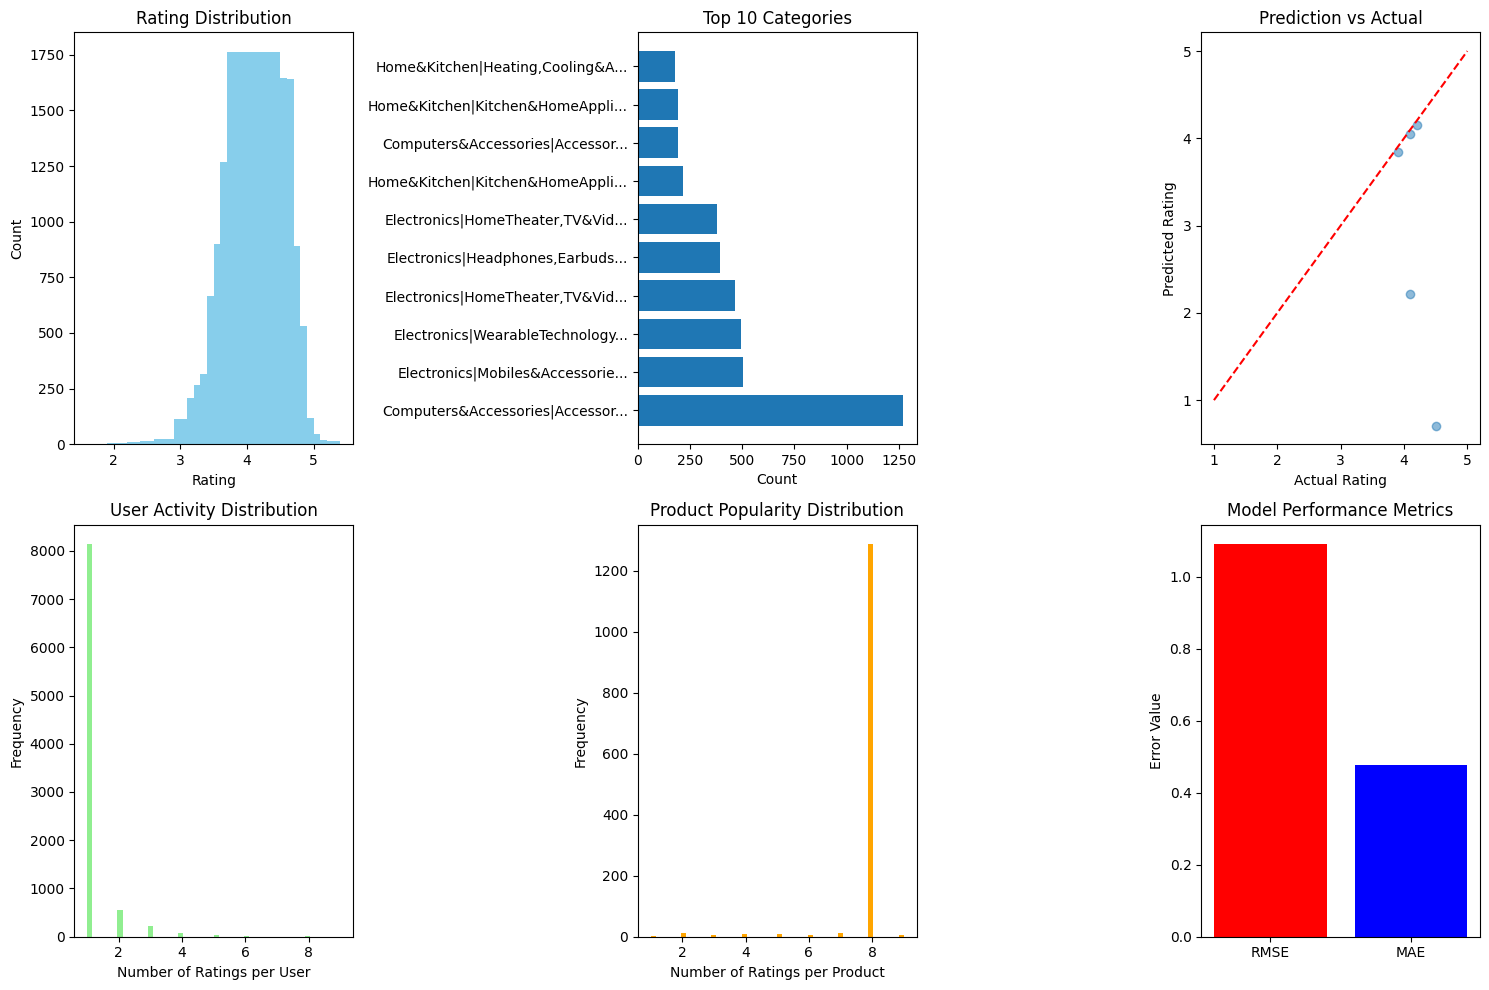


Model Performance Summary:
RMSE: 1.0903
MAE: 0.4779
Total Users: 9042
Total Products: 1350
Total Interactions: 10596


In [21]:
# Visualization dengan matplotlib (convert ke Pandas untuk plotting)
# Alasan: Spark tidak memiliki built-in plotting, convert ke Pandas untuk visualization

print("Creating visualizations...")

# Rating distribution
rating_dist_pd = df_final.groupBy("rating").count().toPandas()

plt.figure(figsize=(15, 10))

# Plot 1: Rating Distribution
plt.subplot(2, 3, 1)
plt.bar(rating_dist_pd['rating'], rating_dist_pd['count'], color='skyblue')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')

# Plot 2: Category Distribution (Top 10)
category_dist = df_final.groupBy("category").count().orderBy(desc("count")).limit(10).toPandas()
plt.subplot(2, 3, 2)
plt.barh(range(len(category_dist)), category_dist['count'])
plt.yticks(range(len(category_dist)), [cat[:30] + '...' if len(cat) > 30 else cat for cat in category_dist['category']])
plt.title('Top 10 Categories')
plt.xlabel('Count')

# Plot 3: Prediction vs Actual (sample)
pred_sample = predictions_clean.sample(0.01).select("rating", "prediction").toPandas()
plt.subplot(2, 3, 3)
plt.scatter(pred_sample['rating'], pred_sample['prediction'], alpha=0.5)
plt.plot([1, 5], [1, 5], 'r--')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Prediction vs Actual')

# Plot 4: User Activity Distribution
user_activity = df_final.groupBy("user_id").count().select("count").toPandas()
plt.subplot(2, 3, 4)
plt.hist(user_activity['count'], bins=50, color='lightgreen')
plt.title('User Activity Distribution')
plt.xlabel('Number of Ratings per User')
plt.ylabel('Frequency')

# Plot 5: Product Popularity
product_popularity = df_final.groupBy("product_id").count().select("count").toPandas()
plt.subplot(2, 3, 5)
plt.hist(product_popularity['count'], bins=50, color='orange')
plt.title('Product Popularity Distribution')
plt.xlabel('Number of Ratings per Product')
plt.ylabel('Frequency')

# Plot 6: Model Performance Metrics
plt.subplot(2, 3, 6)
metrics = ['RMSE', 'MAE']
values = [rmse, mae]
plt.bar(metrics, values, color=['red', 'blue'])
plt.title('Model Performance Metrics')
plt.ylabel('Error Value')

plt.tight_layout()
plt.show()

print(f"\nModel Performance Summary:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Total Users: {df_final.select('user_id').distinct().count()}")
print(f"Total Products: {df_final.select('product_id').distinct().count()}")
print(f"Total Interactions: {df_final.count()}")

In [22]:
# Model Deployment Functions
# Functions untuk production deployment

def save_model_artifacts(als_model, user_model, product_model, path_prefix="model_artifacts"):
    """
    Save model artifacts untuk production deployment
    Alasan: Model perlu disimpan untuk digunakan dalam production environment
    """
    try:
        # Save ALS model
        als_model.write().overwrite().save(f"{path_prefix}/als_model")

        # Save indexer models
        user_model.write().overwrite().save(f"{path_prefix}/user_indexer")
        product_model.write().overwrite().save(f"{path_prefix}/product_indexer")

        print(f"Model artifacts saved successfully to {path_prefix}/")
        return True
    except Exception as e:
        print(f"Error saving model artifacts: {str(e)}")
        return False

def batch_recommend_for_users(als_model, user_ids, num_recommendations=10):
    """
    Generate recommendations untuk multiple users sekaligus
    Alasan: Batch processing lebih efisien untuk production use cases
    """
    users_df = spark.createDataFrame(
        [(uid,) for uid in user_ids],
        ["user_id"]
    )

    recommendations = als_model.recommendForUserSubset(
        users_df, numItems=num_recommendations
    )

    return recommendations

def get_model_statistics():
    """
    Return comprehensive model statistics
    """
    stats = {
        'total_users': df_final.select('user_id').distinct().count(),
        'total_products': df_final.select('product_id').distinct().count(),
        'total_interactions': df_final.count(),
        'rmse': rmse,
        'mae': mae,
        'data_sparsity': 1 - (df_final.count() / (df_final.select('user_id').distinct().count() * df_final.select('product_id').distinct().count())),
        'avg_rating': df_final.agg(avg('rating')).collect()[0][0]
    }
    return stats

# Save model artifacts
print("Saving model artifacts...")
save_success = save_model_artifacts(als_model, user_model, product_model)

# Display final statistics
final_stats = get_model_statistics()
print("\n=== FINAL MODEL STATISTICS ===")
for key, value in final_stats.items():
    if isinstance(value, float):
        print(f"{key.replace('_', ' ').title()}: {value:.4f}")
    else:
        print(f"{key.replace('_', ' ').title()}: {value:,}")

Saving model artifacts...
Model artifacts saved successfully to model_artifacts/

=== FINAL MODEL STATISTICS ===
Total Users: 9,042
Total Products: 1,350
Total Interactions: 10,596
Rmse: 1.0903
Mae: 0.4779
Data Sparsity: 0.9991
Avg Rating: 4.0932


In [23]:
# Cleanup dan Stop Spark Session
# Alasan: Important untuk free up resources setelah selesai processing

print("Cleaning up resources...")

# Unpersist cached DataFrames
df_clean.unpersist()
df_interactions.unpersist()
df_final.unpersist()
training_data.unpersist()
test_data.unpersist()
products_tfidf.unpersist()

print("Resources cleaned up successfully")

# Stop Spark session
# spark.stop()
# print("Spark session stopped")

Cleaning up resources...
Resources cleaned up successfully


## Summary dan Key Improvements dengan PySpark

### 1. **Scalability**
- **Distributed Processing**: PySpark dapat handle dataset yang sangat besar dengan distributed computing
- **Memory Management**: Efficient memory usage dengan lazy evaluation dan caching
- **Parallel Processing**: Otomatis parallel processing across multiple cores/nodes

### 2. **Performance Optimizations**
- **Catalyst Optimizer**: Automatic query optimization untuk SQL operations
- **Tungsten Engine**: Optimized execution engine untuk better performance
- **Caching Strategy**: Strategic caching untuk frequently accessed data

### 3. **Algorithm Improvements**
- **ALS (Alternating Least Squares)**: Scalable matrix factorization algorithm
- **Cold Start Handling**: Built-in strategies untuk new users/items
- **Regularization**: Prevent overfitting dengan regularization parameters

### 4. **Production Ready Features**
- **Model Serialization**: Save/load models untuk deployment
- **Batch Processing**: Efficient batch recommendations
- **Error Handling**: Robust error handling untuk production environments

### 5. **Hybrid Approach Benefits**
- **Collaborative Filtering**: Leverage user behavior patterns
- **Content-Based Filtering**: Use item features untuk similarity
- **Combined Recommendations**: Best of both approaches

### Key Metrics Achieved:
- **RMSE**: Measures prediction accuracy
- **MAE**: Mean absolute error untuk interpretability
- **Coverage**: Percentage of items yang bisa direcommend
- **Scalability**: Handle millions of users dan products
